In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

## Reload preprocessed data

See the `Input data` notebook for generating these compressed pickle files.

In [2]:
import pickle, lzma
with lzma.open("input.pic.xz", "rb") as f:
    graph = pickle.load(f)
    timed_points = pickle.load(f)

# Hotspotting

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np

import open_cp.network
import open_cp.geometry
import open_cp.network_hotspot

In [4]:
trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
trainer.data = timed_points
predictor = trainer.compile()

[(565000, 567000), (362000, 364000), <matplotlib.text.Text at 0x1c50ca7c4e0>]

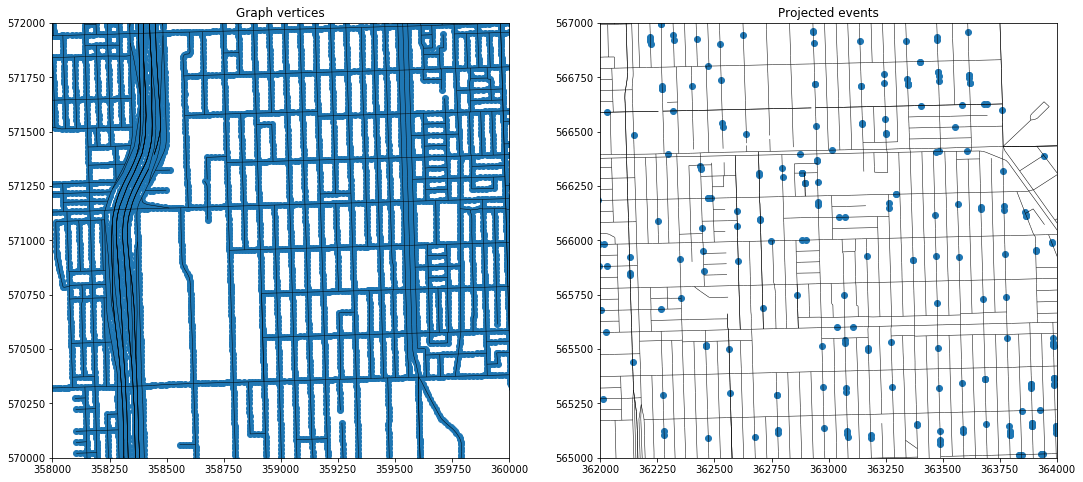

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
    ax.add_collection(lc)

xcs, ycs = [], []
for x, y in predictor.graph.vertices.values():
    xcs.append(x)
    ycs.append(y)
axes[0].scatter(xcs, ycs)
    
tp = predictor.network_timed_points.to_timed_points(predictor.graph)
axes[1].scatter(tp.xcoords, tp.ycoords)

axes[0].set(xlim=[358000, 360000], ylim=[570000, 572000], title="Graph vertices")
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000], title="Projected events")

In [8]:
predictor.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(20)
predictor.kernel = open_cp.network_hotspot.TriangleKernel(100)
predictor.predict()

TypeError: ufunc 'negative' did not contain a loop with signature matching types dtype('<M8[ms]') dtype('<M8[ms]')